<a href="https://colab.research.google.com/github/RiccardoRobb/BigData_project/blob/main/BigData_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter sentiment analysis**
### BigData 2023 project

[@Author](https://github.com/RiccardoRobb): Riccardo Ruberto 1860609

---
## **Inital configuration**
### PySpark installation

In [1]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Useful imports

In [2]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Spark configuration

In [3]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "8000").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("Twitter sentiment analysis").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Check spark configurations

In [4]:
spark

In [5]:
sc._conf.getAll()

[('spark.app.submitTime', '1687529532493'),
 ('spark.driver.memory', '45G'),
 ('spark.driver.port', '45979'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1687529532927'),
 ('spark.ui.port', '8000'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UN

---
## Load dataset [***Sentiment140***]
### Download dataset

In [6]:
! wget https://raw.githubusercontent.com/RiccardoRobb/BigData_project/main/Sentiment140.zip

! unzip "./*.zip" && rm *.zip
! mv training.1600000.processed.noemoticon.csv train140.csv

--2023-06-23 14:12:22--  https://raw.githubusercontent.com/RiccardoRobb/BigData_project/main/Sentiment140.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84855679 (81M) [application/zip]
Saving to: ‘Sentiment140.zip’

Sentiment140.zip    100%[===================>]  80.92M   150MB/s    in 0.5s    

2023-06-23 14:12:23 (150 MB/s) - ‘Sentiment140.zip’ saved [84855679/84855679]

Archive:  ./Sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


### Create data frame [***Sentiment140***]
1600000 tweets

In [7]:
schema = StructType([ \
    StructField("target",IntegerType(),True), \
    StructField("id",LongType(),True), \
    StructField("full_date",StringType(),True), \
    StructField("flag", StringType(), True), \
    StructField("user", StringType(), True), \
    StructField("text", StringType(), True) \
  ])

df = spark.read.csv('./train140.csv', schema=schema, header="false")

---
## **Inital cleaning**
### Removal of unnecessary columns

In [8]:
# sentiment of the tweet is not affected by the "user"
df = df.drop("user")

# verify "flag" utility
print(df.select(countDistinct("flag")).collect()[0][0])

# "flag" has only one value == NO_QUERY, so I delete it
df = df.drop("flag")

1


### From ***date*** to ***day_name***; ***hour***; ***date***

In [9]:
months_map = {"Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06", "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"}

convert_date_udf = udf(lambda month_name : months_map[month_name], StringType())

### From **hour:min:mill** to int **hour**

In [10]:
convert_hour_udf = udf(lambda time: int(time[:2]), IntegerType())

In [11]:
split_col = pyspark.sql.functions.split(df['full_date'], ' ')

df = df.withColumn("day_name", split_col.getItem(0)) \
      .withColumn("hour", convert_hour_udf(split_col.getItem(3))) \
      .withColumn("date", to_date( concat_ws("-", split_col.getItem(2), convert_date_udf(split_col.getItem(1)), split_col.getItem(5)), "dd-MM-yyyy"))

df = df.drop("full_date")

---
## **Data analysis**
### ***target*** values analisys

In [12]:
df.select("target").distinct().show()
# "target" value is or 0 or 4

+------+
|target|
+------+
|     4|
|     0|
+------+



In [13]:
sad_tweets = df.filter(col("target") == 0)
happy_tweets = df.filter(col("target") == 4)

print("Sad tweets = ", sad_tweets.count())
print("Happy tweets = ", happy_tweets.count())

Sad tweets =  800000
Happy tweets =  800000


Sad tweets and happy tweets are balanced.

### Time frame of interest

In [14]:
print("Min date = ", df.select(min(df.date)).collect()[0][0])
print("Max date = ", df.select(max(df.date)).collect()[0][0])

Min date =  2009-04-06
Max date =  2009-06-25


The time frame used is too small, datas were collected in 2 months. \\
*Using data column will be useful only if we try to predict tweets written during the [2009-04-06, 2009-06-25] period.*

### Better to delete the ***date*** column

In [15]:
df = df.drop("date")

---
## **Data processing**
### Case normalization

In [16]:
# used for all columns to see if null values are present
# df.filter(col("text").isNull()).show()

df = df.withColumn("text", lower(col("text")))

### Username and links removal

In [17]:
import re

# twitter ids can contain alphanumeric and '_' characters
username_regex = r"@[A-Za-z0-9_]+"

# http:// / https:// links
link_regex1 = r"https?://[^ ]+"

# www. links
link_regex2 = r"www.[^ ]+"


master_regex = r"|".join((username_regex, link_regex1, link_regex2))

df = df.withColumn("text", regexp_replace(df.text, master_regex, ""))

### Filter out punctual symbols

In [18]:
df = df.withColumn("text", regexp_replace(df.text, "[^a-zA-Z\s]", ""))

### Trimming

In [19]:
df = df.withColumn("text", trim(col("text")))

# extra whitespaces
df = df.withColumn("text", trim(regexp_replace(df.text, " +", " ")))

### Tokenization

In [20]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "text", outputCol = "tokens")
tokens_df = tokenizer.transform(df)

### Stopwords removal

In [21]:
from pyspark.ml.feature import StopWordsRemover

stopwords_remover = StopWordsRemover(inputCol = "tokens", outputCol = "terms")
terms_df = stopwords_remover.transform(tokens_df)

### Stemming

In [22]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language = "english")
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))


tweets_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))

### Removal of unnecessary columns

In [23]:
tweets_df = tweets_df.drop("id", "text", "tokens", "terms")

tweets_df.show(7, truncate = False)

+------+--------+----+-----------------------------------------------------------------------------------+
|target|day_name|hour|terms_stemmed                                                                      |
+------+--------+----+-----------------------------------------------------------------------------------+
|0     |Mon     |22  |[awww, that, bummer, shoulda, got, david, carr, third, day, d]                     |
|0     |Mon     |22  |[upset, cant, updat, facebook, text, might, cri, result, school, today, also, blah]|
|0     |Mon     |22  |[dive, mani, time, ball, manag, save, rest, go, bound]                             |
|0     |Mon     |22  |[whole, bodi, feel, itchi, like, fire]                                             |
|0     |Mon     |22  |[behav, im, mad, cant, see]                                                        |
|0     |Mon     |22  |[whole, crew]                                                                      |
|0     |Mon     |22  |[need, hug]    

---
## **Additional cleaning**

In [24]:
tweets_df.cache()

tweets_df = tweets_df.filter(size(tweets_df.terms_stemmed) > 1)

sad_tweets = tweets_df.filter(tweets_df.target == 0)
happy_tweets = tweets_df.filter(tweets_df.target == 4)

sad_tweets_count = sad_tweets.count()
happy_tweets_count = happy_tweets.count()

print("Sad tweets = ", sad_tweets_count)
print("Happy tweets = ", happy_tweets_count)

Sad tweets =  774763
Happy tweets =  767489


### After the cleaning Sad and Happy tweets are ***unbalanced***

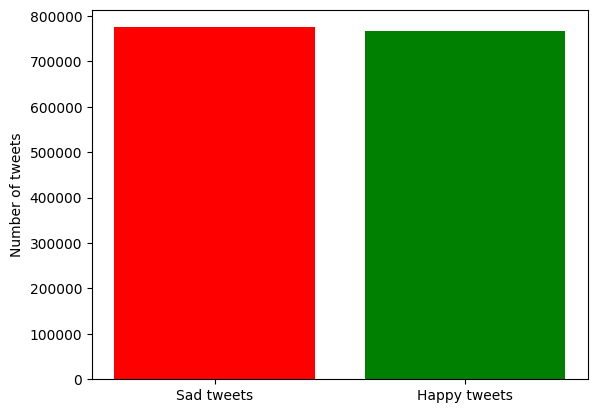

In [25]:
(figure_, axes_) = plt.subplots()

y = [sad_tweets_count, happy_tweets_count]
axes_.set_ylabel("Number of tweets")

x = ["Sad tweets", "Happy tweets"]

axes_.bar(x, y, color = ["red", "green"])
plt.show()

### Balancing dataframes

In [26]:
sad_tweets = sad_tweets.select("*").orderBy(rand())
sad_tweets = sad_tweets.limit(happy_tweets_count)

tweets_df = sad_tweets.union(happy_tweets)

---
## **Word Vector representation**

### Load **GloVe** embeddings

In [27]:
import gensim.downloader as api

embeddings = 100
word2vector = None

if word2vector == None:
  word2vector = api.load("glove-twitter-" + str(embeddings))

### Mapping tokens - embeddings

In [28]:
extractor_udf = udf(lambda tokens: [[float(x) for x in word2vector[token]] if token in word2vector else [float(0.0)]*word2vector["tweet"].shape[0] for token in tokens], ArrayType((ArrayType(FloatType()))))

avg_embedding_udf = udf(lambda x :[float(y) for y in np.mean(x, axis = 0)])

tweets_embedded = tweets_df.withColumn("tweet_embeddings", extractor_udf("terms_stemmed"))
tweets_embedded = tweets_embedded.withColumn("tweet_embeddings", avg_embedding_udf("tweet_embeddings"))

tweets_embedded.printSchema()
tweets_embedded.show(7, truncate = False)


root
 |-- target: integer (nullable = true)
 |-- day_name: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- terms_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tweet_embeddings: string (nullable = true)

+------+--------+----+---------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Conversion from `ArrayType( ArrayType( Float() ) )` to `VectorUDT()`

In [29]:
from pyspark.ml.linalg import Vectors, VectorUDT

to_vector_udf = udf(lambda embedded: Vectors.dense(embedded), VectorUDT())

tweets_embedded = tweets_embedded.withColumn("tweet_embeddings", to_vector_udf(tweets_embedded.tweet_embeddings))


---
## **Train and Test setup**

In [30]:
tweets_embedded.cache()

(train_df, test_df) = tweets_embedded.randomSplit([0.8, 0.2], seed=1234)

train_df.show(5)

+------+--------+----+--------------------+--------------------+
|target|day_name|hour|       terms_stemmed|    tweet_embeddings|
+------+--------+----+--------------------+--------------------+
|     0|     Fri|   0|[aaaaaaa, cant, l...|[-0.1621966560681...|
|     0|     Fri|   0|[aah, must, go, b...|[0.07020000517368...|
|     0|     Fri|   0|[aargh, that, old...|[0.18359609456224...|
|     0|     Fri|   0|[absent, im, sick...|[-0.0620203393821...|
|     0|     Fri|   0|[absolut, posit, ...|[-0.2770353769883...|
+------+--------+----+--------------------+--------------------+
only showing top 5 rows



---
## Verify data

In [31]:
tweets_embedded.printSchema()
tweets_embedded.show(10)

print("tot = ", tweets_embedded.count())

root
 |-- target: integer (nullable = true)
 |-- day_name: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- terms_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tweet_embeddings: vector (nullable = true)

+------+--------+----+--------------------+--------------------+
|target|day_name|hour|       terms_stemmed|    tweet_embeddings|
+------+--------+----+--------------------+--------------------+
|     0|     Thu|   6|[here, ad, comedi...|[-0.2462591119110...|
|     0|     Tue|   6|[work, wish, fun,...|[-0.0469049983657...|
|     0|     Sat|   7|[famous, last, word]|[0.09697666267553...|
|     0|     Thu|  12|[im, sorri, angth...|[-0.1163321544632...|
|     0|     Sun|   6|[anoth, fire, ala...|[0.07818459719419...|
|     0|     Sun|  15|[cross, sword, co...|[-0.0818263698707...|
|     0|     Mon|   5|[kari, rear, end,...|[0.12290666500727...|
|     0|     Sun|  12|[graduat, magnet,...|[-0.0203249827027...|
|     0|     Mon|  19| 

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

# TODO
* **Are useful tokens with len==1 ?**
* **chek udf validity for month mapping**
* **validation set?**